Iter 99 - Loss: 4.744
Iter 199 - Loss: 2.332
Iter 299 - Loss: 1.287
Iter 399 - Loss: 0.804
Iter 499 - Loss: 0.563
Iter 599 - Loss: 0.434
Iter 699 - Loss: 0.364
Iter 799 - Loss: 0.327
Iter 899 - Loss: 0.306
Iter 999 - Loss: 0.294


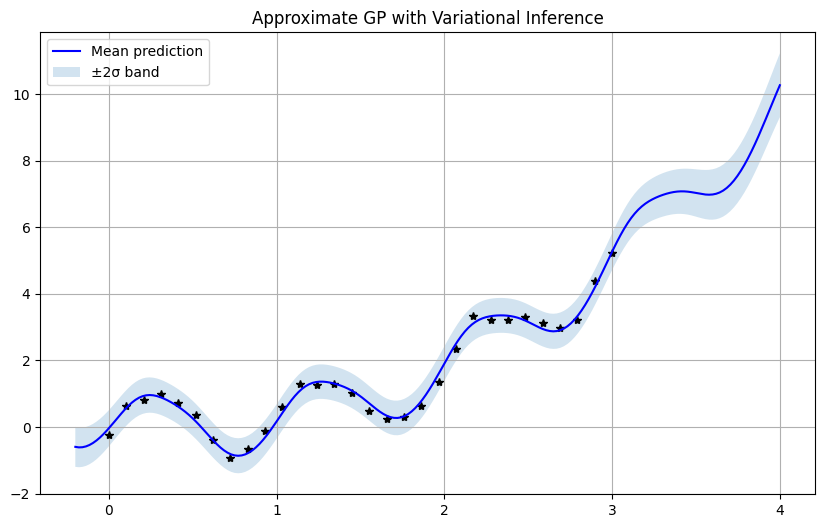

In [172]:
import torch
import gpytorch
from matplotlib import pyplot as plt

# Generate training data
train_x = torch.linspace(0, 3, 30)
train_y = torch.sin(train_x * (2 * torch.pi)) + torch.randn(train_x.size()) * 0.2 + train_x**3 * 0.2
train_x = train_x.unsqueeze(-1)

# Likelihood
likelihood = gpytorch.likelihoods.GaussianLikelihood(
    noise_constraint=gpytorch.constraints.Interval(0.01, .1)  # Set noise constraint
)

# Define the variational GP model
class ApproximateGPModel(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points):
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(inducing_points.size(0))
        variational_strategy = gpytorch.variational.VariationalStrategy(
            self, inducing_points, variational_distribution, learn_inducing_locations=True
        )
        super().__init__(variational_strategy)
        
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = (
            (gpytorch.kernels.RBFKernel())
            +
            (gpytorch.kernels.PolynomialKernel(power=2))
            +
            (gpytorch.kernels.PeriodicKernel())
            
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# Inducing points
inducing_points = torch.linspace(0, 1, 30).unsqueeze(-1)

# Instantiate model
model = ApproximateGPModel(inducing_points)
mll = gpytorch.mlls.VariationalMarginalLogLikelihood(likelihood, model, num_data=train_y.size(0))

model.train()
likelihood.train()

optimizer = torch.optim.Adam(model.parameters(), lr=0.2, amsgrad=False)

for i in range(1000):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    if (i + 1) % 100 == 0:
        print(f"Iter {i} - Loss: {loss.item():.3f}")
    optimizer.step()


model.eval()
likelihood.eval()

test_x = torch.linspace(-0.2, 4, 200).unsqueeze(-1)
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    preds = likelihood(model(test_x))

mean = preds.mean
lower, upper = preds.confidence_region()

plt.figure(figsize=(10, 6))
plt.plot(train_x.numpy(), train_y.numpy(), 'k*')
plt.plot(test_x.numpy(), mean.numpy(), 'b', label='Mean prediction')
plt.fill_between(test_x.squeeze(), lower, upper, alpha=0.2, label='±2σ band')
plt.legend()
plt.title("Approximate GP with Variational Inference")
plt.grid(True)
plt.show()


In [161]:
import pandas as pd

In [154]:
pd.Series({name: param.detach().numpy().item() for name, param in model.covar_module.named_parameters()})

kernels.0.raw_lengthscale      2.108521
kernels.1.raw_offset          -1.349351
kernels.2.raw_lengthscale      1.801682
kernels.2.raw_period_length    0.514948
dtype: float64

In [159]:
list(model.covar_module.named_children())[0][1][1]

PolynomialKernel(
  (raw_offset_constraint): Positive()
)